# Combine dat files from unattended ApRES surveys on Thwaites glacier into netcdfs for archiving
### J. Kingslake, July 2nd 2025
The code below collates the dat files collected in unattended ApRES surveys on Thwaites Glacier between 2022 and 2024 by the GHOST team, part of the International Thwaites Glacier Collaboration. The data were collected by Elizabeth Case, Columbia University, then Utrecht University, Andrew Hoffman, Columbia University, then Rice University, and Ole Zeisling, Alfred Wegner Institute.

In [9]:
import sys
sys.path.append("/Users/jkingslake/Documents/science/ApRES/xapres")
import xapres as xa
import xarray as xr
import os
import matplotlib.pyplot as plt
import rioxarray
import pandas as pd
import glob

Define where the dat files are and where we will write the netcdfs.

In [4]:
sites = ["ApRES_LTG", "ApRES_Lake1", "ApRES_Lake2", "ApRES_Takahe1_204", "ApRES_Takahe2_203"]
source = "/Users/jkingslake/Documents/data/thwaites_apres/archiving/unattended/"
archive_location ='/Users/jkingslake/Documents/data/thwaites_apres/archiving/unattended'

Define a function for changing the format of the attributes in the xarray to work nicely when written to netcdf. 

In [5]:
def remove_constants_attr(ds):
    for c in ds.attrs['constants']:
        ds.attrs[c] = ds.attrs['constants'][c]
    del ds.attrs['constants']
    return ds


## Add missing position cvs for Takahe sites

In [6]:
df = pd.DataFrame({
    'Station': [sites[3]],
    'Latitude': [-76.4175],
    'Longitude': [-111.2536]
})
df.set_index('Station', inplace=True)
df.to_csv(os.path.join(archive_location, sites[3], sites[3] + ".csv"))

df = pd.DataFrame({
    'Station': [sites[4]],
    'Latitude': [-76.4435],
    'Longitude': [-110.1136]
})
df.set_index('Station', inplace=True)
df.to_csv(os.path.join(archive_location, sites[4], sites[4] + ".csv"))

Loop through the locations and:
1. find all the dat files, subset them, and sort them by filename, so that they are in time order. 
2. Split the list of dat files into blocks with a size that results in reasonably sized netcdfs. 
3. Define netcdf paths and make directories for them
4. Delete previously created netcdfs 
5. Loop through the blocks of files and load all the dat files into an xarray using the package xapres
6. Add the stacked chirps
7. Tidy up the units and attributes to work well with netcdfs
8. Write the netcdfs
(the last three steps are performed for each block of files) 

In [10]:
for site in sites:
    nc_directory = os.path.join(source, site, "netcdf")
    # remove files
    for f in glob.glob(nc_directory + "/*.nc"):
        os.remove(f)

In [11]:
tg_1 = xa.load.from_dats()
for site in sites:
    # 1. find all the dat files, subset them, and sort them by filename, so that they are in time order. 
    dat_directory = os.path.join(source, site, "dat_files")
    filepaths = tg_1.list_files(directory=dat_directory)
    print(f"there are {len(filepaths)} files from {site}")
    one_dat = tg_1.load_all(directory = dat_directory, file_numbers_to_process=[7], computeProfiles = False, disable_progress_bar=True)
    print(f"total size of dataset without profiles computed = {one_dat.nbytes/1e9 * len(filepaths):.2f} GB in memory")

    # load position information
    w = pd.read_csv(os.path.join(archive_location, site, site + ".csv"))

    if site == 'ApRES_LTG': 
        start_dat_file_number = 4  # the first 4 use the same attenuator settings, but they are not regularly spaces in time with the other data
    elif site == 'ApRES_Lake1':
        start_dat_file_number = 3  # the first 3 use different attenuator settings. This is the first one which is regularly spaced in time with the other data
    elif site == 'ApRES_Lake2':
        start_dat_file_number = 4  # This is the first one which is regularly spaced in time with the other data
    elif site == 'ApRES_Takahe1_204':
        start_dat_file_number = 0
    elif site == 'ApRES_Takahe2_203':
        start_dat_file_number = 3 # something is up with the first 3 files some seem to have no data and one is the wrong size. 
    else:
        raise ValueError(f"Unknown site {site}")

    dat_size = os.path.getsize(filepaths[start_dat_file_number+5])
    print(f"dat file size = {dat_size/1e6:.2f} MB on disk")

    f = sorted(filepaths)[start_dat_file_number:]

    # 2. Split the list of dat files into blocks with a size that results in reasonably sized netcdfs. 
    N = int(8*104e6/dat_size)  # number of files to process in each block
    file_lists = [f[i:i + N] for i in range(0, len(f), N)]
    print(f'created {len(file_lists)} file lists from {len(f)} files')
    print(f'list sizes: {[len(x) for x in file_lists]}')

    # 3. Define netcdf paths and make directories for them
    nc_locations = [f'{archive_location}/{site}/netcdf/{site}_{i}.nc' for i in range(len(file_lists))]
    os.makedirs(f"{archive_location}/{site}/netcdf", exist_ok=True) 
    
    # 4. Delete previously created netcdfs 
    for nc in nc_locations:
        if os.path.exists(nc):
            print(f"deleting existing file {nc}")
            os.remove(nc)

    # 5. loop through the blocks of files and load all the dat files into an xarray using the package xapres
    for i, file_list in enumerate(file_lists):
        print(f"Processing {len(file_list)} files")
        ds = tg_1.load_all(directory = dat_directory, 
                        computeProfiles = False,
                        file_names_to_process=file_list,
                        disable_progress_bar=False)
        
        # 6. add the stacked chirps
        ds['chirp_stacked'] = ds.chirp.mean(dim='chirp_num', keep_attrs=True)
        
        # 7. tidy up the units and attributes to work well with netcdfs
        ds.chirp_stacked.attrs['long_name'] = 'stacked de-ramped chirp'
        ds["chirp_time"].attrs["units"] = "unscaled seconds"
        ds = remove_constants_attr(ds)

        # add position info from csvs
        ds=ds.assign_coords(lat=w.Latitude.values[0]).assign_coords(lon=w.Longitude.values[0])
        ds.rio.write_crs("EPSG:4326", inplace=True)
        ds.lat.attrs['long_name'] = 'latitude'
        ds.lat.attrs['units'] = 'degrees_north'
        ds.lat.attrs['notes'] = 'From hand-held GPS in field. See spatial_ref coordinate for more information'
        ds.lon.attrs['long_name'] = 'longitude'
        ds.lon.attrs['units'] = 'degrees_east'
        ds.lon.attrs['notes'] = 'From hand-held GPS in field. See spatial_ref coordinate for more information'

        ds.attrs= {key: value for key, value in ds.attrs.items() if key == 'processing'}
        ds.attrs['readme'] = 'Unattended autonomous radio-echo sounder (ApRES) measurements recorded on Thwaites Glacier in the 2022-23 and 2023-24 seasons. Collected by Elizabeth Case, Columbia University, then Utrecht University, Andrew Hoffman, Columbia University, then Rice University, and Ole Zeising, Alfred Wegner Institute. Funded by NSF-NERC grant number 1738934.'

        # 8. write the netcdfs
        print(f"Writing netcdf to {nc_locations[i]}")
        ds.to_netcdf(nc_locations[i])
    print(f"Finished processing {site} with {len(file_lists)} netcdfs created")
    print('------------------------------------------------------')


there are 181 files from ApRES_LTG
total size of dataset without profiles computed = 11.64 GB in memory
dat file size = 8.00 MB on disk
created 2 file lists from 177 files
list sizes: [103, 74]
Processing 103 files


100%|██████████| 103/103 [00:03<00:00, 28.82it/s]


Writing netcdf to /Users/jkingslake/Documents/data/thwaites_apres/archiving/unattended/ApRES_LTG/netcdf/ApRES_LTG_0.nc
Processing 74 files


100%|██████████| 74/74 [00:02<00:00, 29.10it/s]


Writing netcdf to /Users/jkingslake/Documents/data/thwaites_apres/archiving/unattended/ApRES_LTG/netcdf/ApRES_LTG_1.nc
Finished processing ApRES_LTG with 2 netcdfs created
------------------------------------------------------
there are 185 files from ApRES_Lake1
total size of dataset without profiles computed = 11.90 GB in memory
dat file size = 16.00 MB on disk
created 4 file lists from 182 files
list sizes: [51, 51, 51, 29]
Processing 51 files


100%|██████████| 51/51 [00:01<00:00, 31.39it/s]


Writing netcdf to /Users/jkingslake/Documents/data/thwaites_apres/archiving/unattended/ApRES_Lake1/netcdf/ApRES_Lake1_0.nc
Processing 51 files


100%|██████████| 51/51 [00:01<00:00, 29.37it/s]


Writing netcdf to /Users/jkingslake/Documents/data/thwaites_apres/archiving/unattended/ApRES_Lake1/netcdf/ApRES_Lake1_1.nc
Processing 51 files


100%|██████████| 51/51 [00:01<00:00, 30.40it/s]


Writing netcdf to /Users/jkingslake/Documents/data/thwaites_apres/archiving/unattended/ApRES_Lake1/netcdf/ApRES_Lake1_2.nc
Processing 29 files


100%|██████████| 29/29 [00:01<00:00, 20.79it/s]


Writing netcdf to /Users/jkingslake/Documents/data/thwaites_apres/archiving/unattended/ApRES_Lake1/netcdf/ApRES_Lake1_3.nc
Finished processing ApRES_Lake1 with 4 netcdfs created
------------------------------------------------------
there are 60 files from ApRES_Lake2
total size of dataset without profiles computed = 26.90 GB in memory
dat file size = 112.01 MB on disk
created 8 file lists from 56 files
list sizes: [7, 7, 7, 7, 7, 7, 7, 7]
Processing 7 files


100%|██████████| 7/7 [00:02<00:00,  3.15it/s]


Writing netcdf to /Users/jkingslake/Documents/data/thwaites_apres/archiving/unattended/ApRES_Lake2/netcdf/ApRES_Lake2_0.nc
Processing 7 files


100%|██████████| 7/7 [00:02<00:00,  3.38it/s]


Writing netcdf to /Users/jkingslake/Documents/data/thwaites_apres/archiving/unattended/ApRES_Lake2/netcdf/ApRES_Lake2_1.nc
Processing 7 files


100%|██████████| 7/7 [00:01<00:00,  3.83it/s]


Writing netcdf to /Users/jkingslake/Documents/data/thwaites_apres/archiving/unattended/ApRES_Lake2/netcdf/ApRES_Lake2_2.nc
Processing 7 files


100%|██████████| 7/7 [00:01<00:00,  4.72it/s]


Writing netcdf to /Users/jkingslake/Documents/data/thwaites_apres/archiving/unattended/ApRES_Lake2/netcdf/ApRES_Lake2_3.nc
Processing 7 files


100%|██████████| 7/7 [00:01<00:00,  4.17it/s]


Writing netcdf to /Users/jkingslake/Documents/data/thwaites_apres/archiving/unattended/ApRES_Lake2/netcdf/ApRES_Lake2_4.nc
Processing 7 files


100%|██████████| 7/7 [00:01<00:00,  5.50it/s]


Writing netcdf to /Users/jkingslake/Documents/data/thwaites_apres/archiving/unattended/ApRES_Lake2/netcdf/ApRES_Lake2_5.nc
Processing 7 files


100%|██████████| 7/7 [00:01<00:00,  3.82it/s]


Writing netcdf to /Users/jkingslake/Documents/data/thwaites_apres/archiving/unattended/ApRES_Lake2/netcdf/ApRES_Lake2_6.nc
Processing 7 files


100%|██████████| 7/7 [00:01<00:00,  5.16it/s]


Writing netcdf to /Users/jkingslake/Documents/data/thwaites_apres/archiving/unattended/ApRES_Lake2/netcdf/ApRES_Lake2_7.nc
Finished processing ApRES_Lake2 with 8 netcdfs created
------------------------------------------------------
there are 29 files from ApRES_Takahe1_204
total size of dataset without profiles computed = 12.07 GB in memory
dat file size = 104.02 MB on disk
created 5 file lists from 29 files
list sizes: [7, 7, 7, 7, 1]
Processing 7 files


100%|██████████| 7/7 [00:01<00:00,  4.49it/s]


Writing netcdf to /Users/jkingslake/Documents/data/thwaites_apres/archiving/unattended/ApRES_Takahe1_204/netcdf/ApRES_Takahe1_204_0.nc
Processing 7 files


100%|██████████| 7/7 [00:01<00:00,  3.71it/s]


Writing netcdf to /Users/jkingslake/Documents/data/thwaites_apres/archiving/unattended/ApRES_Takahe1_204/netcdf/ApRES_Takahe1_204_1.nc
Processing 7 files


100%|██████████| 7/7 [00:01<00:00,  4.34it/s]


Writing netcdf to /Users/jkingslake/Documents/data/thwaites_apres/archiving/unattended/ApRES_Takahe1_204/netcdf/ApRES_Takahe1_204_2.nc
Processing 7 files


100%|██████████| 7/7 [00:02<00:00,  3.19it/s]


Writing netcdf to /Users/jkingslake/Documents/data/thwaites_apres/archiving/unattended/ApRES_Takahe1_204/netcdf/ApRES_Takahe1_204_3.nc
Processing 1 files


100%|██████████| 1/1 [00:00<00:00,  4.54it/s]


Writing netcdf to /Users/jkingslake/Documents/data/thwaites_apres/archiving/unattended/ApRES_Takahe1_204/netcdf/ApRES_Takahe1_204_4.nc
Finished processing ApRES_Takahe1_204 with 5 netcdfs created
------------------------------------------------------
there are 34 files from ApRES_Takahe2_203
total size of dataset without profiles computed = 14.16 GB in memory
dat file size = 104.02 MB on disk
created 5 file lists from 31 files
list sizes: [7, 7, 7, 7, 3]
Processing 7 files


100%|██████████| 7/7 [00:01<00:00,  4.78it/s]


Writing netcdf to /Users/jkingslake/Documents/data/thwaites_apres/archiving/unattended/ApRES_Takahe2_203/netcdf/ApRES_Takahe2_203_0.nc
Processing 7 files


100%|██████████| 7/7 [00:01<00:00,  5.45it/s]


Writing netcdf to /Users/jkingslake/Documents/data/thwaites_apres/archiving/unattended/ApRES_Takahe2_203/netcdf/ApRES_Takahe2_203_1.nc
Processing 7 files


100%|██████████| 7/7 [00:01<00:00,  4.63it/s]


Writing netcdf to /Users/jkingslake/Documents/data/thwaites_apres/archiving/unattended/ApRES_Takahe2_203/netcdf/ApRES_Takahe2_203_2.nc
Processing 7 files


100%|██████████| 7/7 [00:01<00:00,  4.31it/s]


Writing netcdf to /Users/jkingslake/Documents/data/thwaites_apres/archiving/unattended/ApRES_Takahe2_203/netcdf/ApRES_Takahe2_203_3.nc
Processing 3 files


100%|██████████| 3/3 [00:00<00:00,  5.43it/s]


Writing netcdf to /Users/jkingslake/Documents/data/thwaites_apres/archiving/unattended/ApRES_Takahe2_203/netcdf/ApRES_Takahe2_203_4.nc
Finished processing ApRES_Takahe2_203 with 5 netcdfs created
------------------------------------------------------


In [ ]:
ds

In [12]:
def reload_and_plot(n):
    print(f"Reloading and plotting data from {archive_location}/{sites[n]}")

    ds = xr.open_mfdataset(f"{archive_location}/{sites[n]}/netcdf/*.nc", engine="netcdf4")

    print (f"Dataset size: {ds.nbytes/1e9:.2f} GB")
    print(f"number of bursts: {ds.sizes['time']}")
    print(f"number of chirps: {ds.sizes['chirp_num']}")

    ds.temperature_1.plot()
    plt.title('Temperature sensor 1')
    plt.show()

    ds.chirp_stacked.plot()
    plt.title('Stacked chirps')
    plt.show()

    ds.close()
    return ds

Reloading and plotting data from /Users/jkingslake/Documents/data/thwaites_apres/archiving/unattended/ApRES_LTG
Dataset size: 11.34 GB
number of bursts: 351
number of chirps: 100


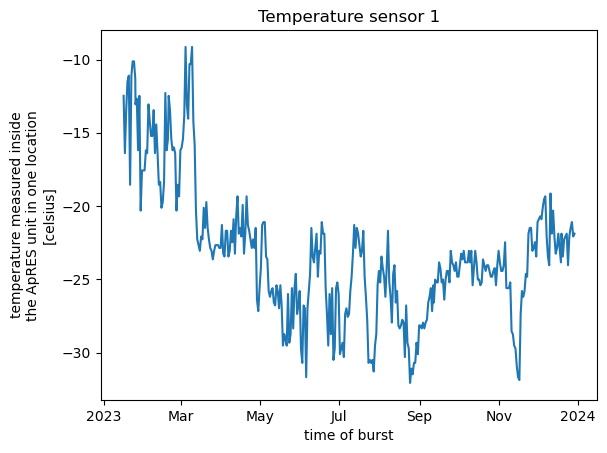

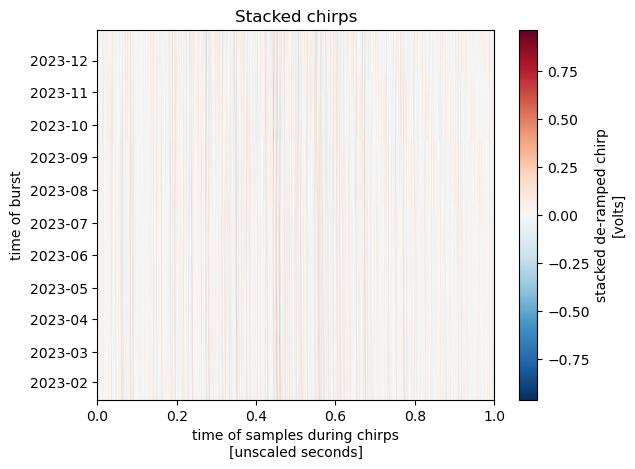

In [13]:
ds = reload_and_plot(0)
lats_0 = ds.latitude.load()
lons_0 = ds.longitude.load()
del ds

Reloading and plotting data from /Users/jkingslake/Documents/data/thwaites_apres/archiving/unattended/ApRES_Lake1
Dataset size: 11.70 GB
number of bursts: 362
number of chirps: 100


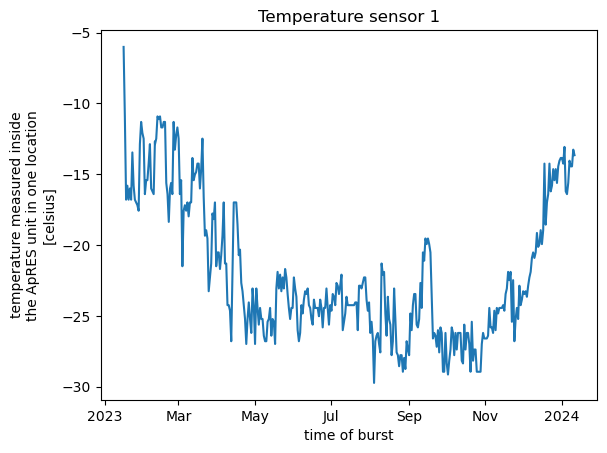

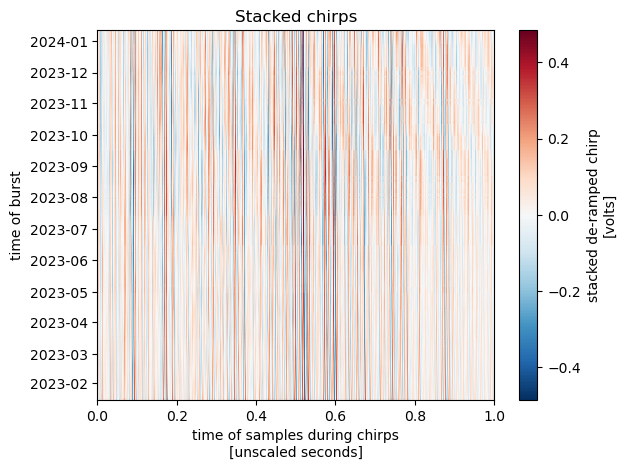

<xarray.Dataset> Size: 12GB
Dimensions:          (time: 362, chirp_num: 100, attenuator_setting_pair: 1,
                      chirp_time: 40001)
Coordinates:
  * time             (time) datetime64[ns] 3kB 2023-01-16T04:22:59 ... 2024-0...
  * chirp_time       (chirp_time) float64 320kB 0.0 2.5e-05 5e-05 ... 1.0 1.0
  * chirp_num        (chirp_num) int64 800B 0 1 2 3 4 5 6 ... 94 95 96 97 98 99
    filename         (time) <U23 33kB 'DATA2023-01-16-0422.DAT' ... 'DATA2024...
    folder_name      (time) <U9 13kB 'dat_files' 'dat_files' ... 'dat_files'
    burst_number     (time) int64 3kB 0 1 0 1 0 1 0 1 0 1 ... 0 1 0 1 0 1 0 1 0
    AFGain           (attenuator_setting_pair) int64 8B dask.array<chunksize=(1,), meta=np.ndarray>
    attenuator       (attenuator_setting_pair) float64 8B dask.array<chunksize=(1,), meta=np.ndarray>
    orientation      (time) <U7 10kB 'unknown' 'unknown' ... 'unknown' 'unknown'
    lat              float64 8B -76.47
    lon              float64 8B -106.9
    spatial_ref      int64 8B 0
Dimensions without coordinates: attenuator_setting_pair
Data variables:
    chirp            (time, chirp_num, attenuator_setting_pair, chirp_time) float64 12GB dask.array<chunksize=(101, 100, 1, 40001), meta=np.ndarray>
    latitude         (time) float64 3kB -76.49 -76.49 -76.49 ... -76.49 -76.49
    longitude        (time) float64 3kB -107.0 -107.0 -107.0 ... -107.0 -107.0
    battery_voltage  (time) float64 3kB dask.array<chunksize=(101,), meta=np.ndarray>
    temperature_1    (time) float64 3kB dask.array<chunksize=(101,), meta=np.ndarray>
    temperature_2    (time) float64 3kB dask.array<chunksize=(101,), meta=np.ndarray>
    chirp_stacked    (time, attenuator_setting_pair, chirp_time) float64 116MB dask.array<chunksize=(101, 1, 40001), meta=np.ndarray>
Attributes:
    processing:  Created on 2025-09-01 16:27:12.380366
    readme:      Unattended autonomous radio-echo sounder (ApRES) measurement...

In [14]:
ds = reload_and_plot(1)
lats_1 = ds.latitude.load()
lons_1 = ds.longitude.load()
ds

Reloading and plotting data from /Users/jkingslake/Documents/data/thwaites_apres/archiving/unattended/ApRES_Lake2
Dataset size: 23.16 GB
number of bursts: 360
number of chirps: 200


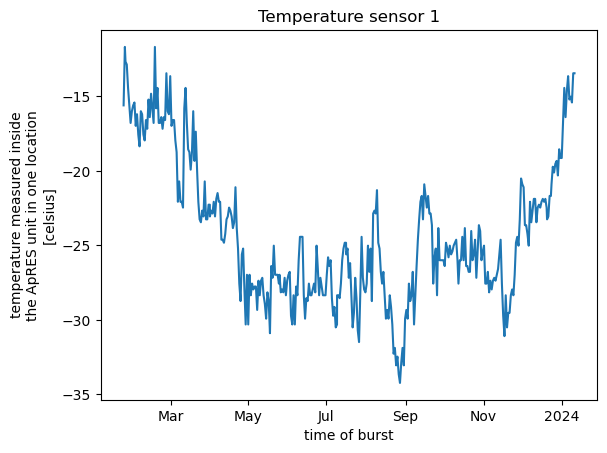

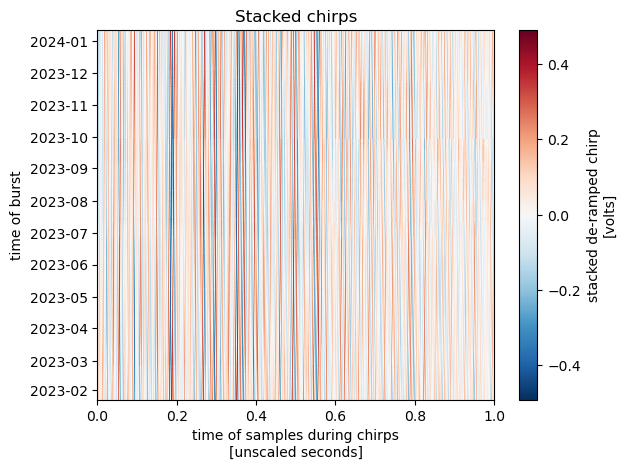

In [15]:
ds = reload_and_plot(2)
lats_2 = ds.latitude.load()
lons_2 = ds.longitude.load()
del ds

Reloading and plotting data from /Users/jkingslake/Documents/data/thwaites_apres/archiving/unattended/ApRES_Takahe1_204
Dataset size: 11.77 GB
number of bursts: 364
number of chirps: 100


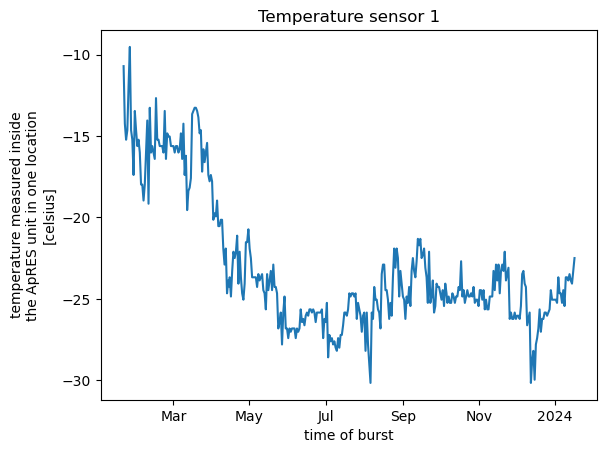

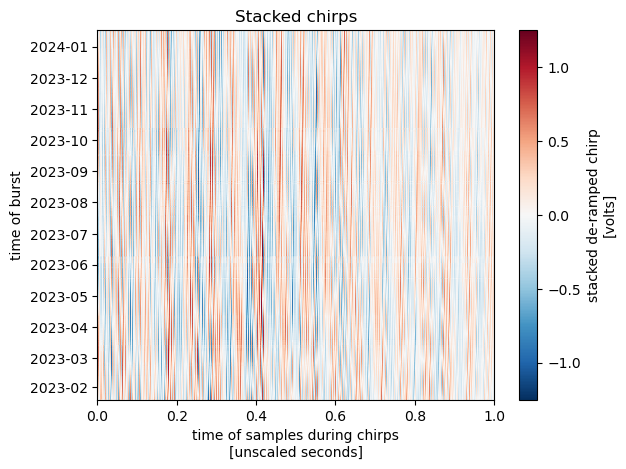

In [16]:
ds = reload_and_plot(3)
lats_3 = ds.latitude.load()
lons_3 = ds.longitude.load()
del ds

Reloading and plotting data from /Users/jkingslake/Documents/data/thwaites_apres/archiving/unattended/ApRES_Takahe2_203
Dataset size: 11.80 GB
number of bursts: 365
number of chirps: 100


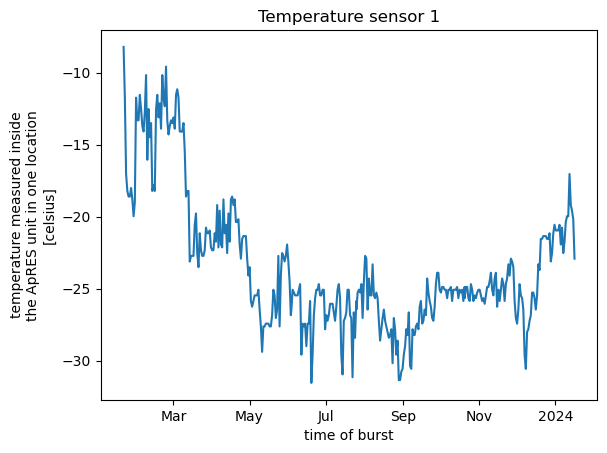

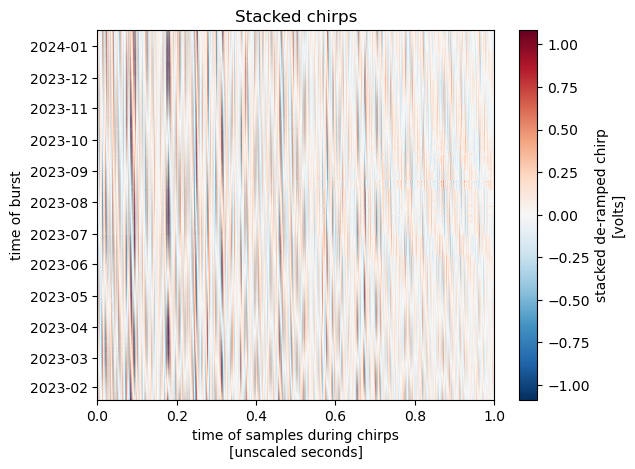

In [17]:
ds = reload_and_plot(4)
lats_4 = ds.latitude.load()
lons_4 = ds.longitude.load()
del ds

(-76.55, -76.38)

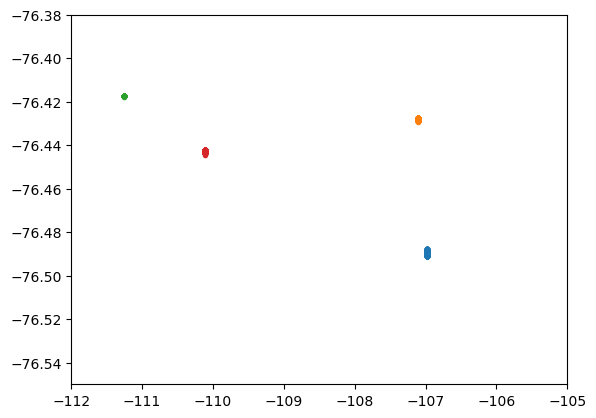

In [19]:
#plt.plot(lons_0.values, lats_0.values, '.', label=sites[0])
plt.plot(lons_1.values, lats_1.values, '.', label=sites[1])
plt.plot(lons_2.values, lats_2.values, '.', label=sites[2])
plt.plot(lons_3.values, lats_3.values, '.', label=sites[3])
plt.plot(lons_4.values, lats_4.values, '.', label=sites[4])
plt.xlim(-112, -105)
plt.ylim(-76.55, -76.38)